# Deep-learning Lab
___

In [18]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
def unpickler(data_location):
    """Opens the pickle files"""
    with open(f"../input/deep-learning-dataset-images/{data_location}.pickle", "rb") as file:
        data = pickle.load(file)
        return data
    
X_train_val = unpickler("X_train_val")
X_val = unpickler("X_val")
X_test = unpickler("X_test")

y_train_val = unpickler("y_train_val")
y_val = unpickler("y_val")
y_test = unpickler("y_test")

y_train_val_labels = unpickler("y_train_val_labels")
y_val_labels = unpickler("y_val_labels")
y_test_labels = unpickler("y_test_labels")

In [20]:
resized_X_train_imgs = []
resized_X_val_imgs = []
resized_X_test_imgs = []
new_img_shape = (100, 100) ## Creats a tuple to be used as the new size for the images

## Changes the size of all the image to make them unified
for item in X_train_val:
    resized_img = cv2.resize(item, new_img_shape)
    resized_X_train_imgs.append(resized_img)

for item in X_val:
    resized_img = cv2.resize(item, new_img_shape)
    resized_X_val_imgs.append(resized_img)

for item in X_test:
    resized_img = cv2.resize(item, new_img_shape)
    resized_X_test_imgs.append(resized_img)

Resizing the images
- Change the shape it resizes to from (360, 500) to (100, 100). 
    - Having (360, 500) gave images that where to heavy changed to (100, 100) for more easier to manage data.
    - I choose (100, 100) because it gave images that wheren't to heavy to work with but also gave information so that the model could learn from them.

In [21]:
## Creats a new numpy array for all the images
X_train_val = np.zeros((len(resized_X_train_imgs), 100, 100, 3))
X_val = np.zeros((len(resized_X_val_imgs), 100, 100, 3))
X_test = np.zeros((len(resized_X_test_imgs), 100, 100, 3))

## Addes the images to the arrays and normalizes thier values
for i, img in enumerate(resized_X_train_imgs):
    X_train_val[i, :, :, :] = img/255

for i, img in enumerate(resized_X_val_imgs):
    X_val[i, :, :, :] = img/255

for i, img in enumerate(resized_X_test_imgs):
    X_test[i, :, :, :] = img/255

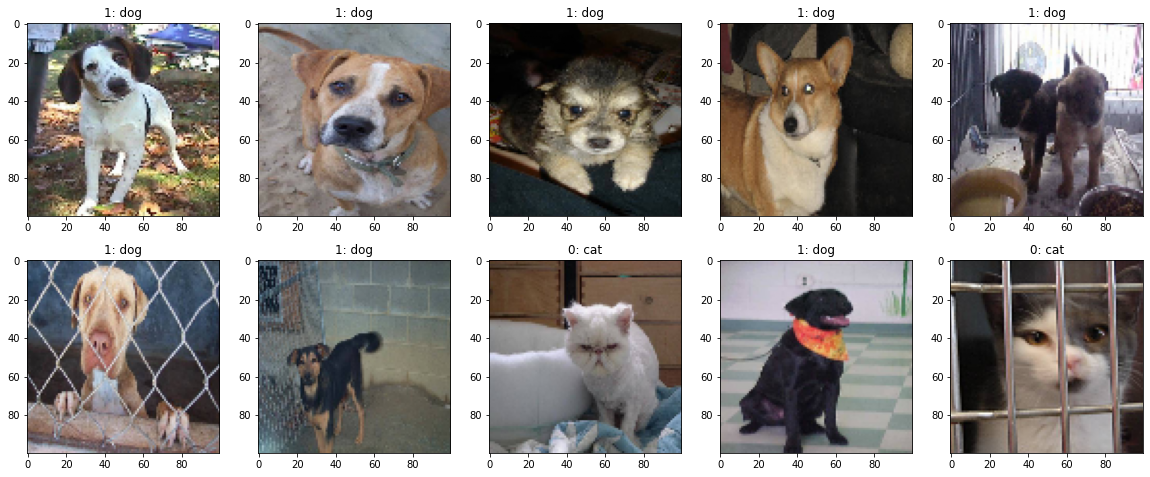

In [22]:
def image_plotter(data): ## Copy of the image plotter for testing if the resize worked
    fig, axes = plt.subplots(2,5, figsize = (20,8))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i])
        ax.set(title = (f"{y_train_val[i]}: {y_train_val_labels[i]}"))
        
image_plotter(X_train_val)

## Data Augmentation

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Creats an ImageDataGenerator object to create augmented images for use as data
train_img_generator = ImageDataGenerator(
    rotation_range = 10,
    shear_range = 0.2,
    horizontal_flip = True
)

## Creats an empty ImageDataGenerator object to create more non augmented images for use as data
val_img_generator = ImageDataGenerator()


X_train_val_gen = train_img_generator.flow(x = X_train_val, y = y_train_val) ## Creats batches of augmented images based on the given images
X_val_gen = val_img_generator.flow(x = X_val, y = y_val) ## Creats batches of images with no augments based on the given images
X_test_gen = val_img_generator.flow(x = X_test, y = y_test)

Changed the amount of degress that the data augmenter can rotate the image by. Because the model can get a harder time predicting with images that have been rotated by 33 degress to either side which will make the model worse.

## CNN model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

## Creats a convolutional neural network with 4 convLayers and 4 maxpooling layers 
cnn_model = Sequential(name = "CNN_model")
cnn_model.add(Conv2D(32, kernel_size = (3,3), activation = "relu"))
cnn_model.add(MaxPooling2D(strides = (2,2), pool_size = (2,2)))
cnn_model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
cnn_model.add(MaxPooling2D(strides = (2,2), pool_size = (2,2)))
cnn_model.add(Conv2D(128, kernel_size = (3,3), activation = "relu"))
cnn_model.add(MaxPooling2D(strides = (2,2), pool_size = (2,2)))
cnn_model.add(Conv2D(128, kernel_size = (3,3), activation = "relu"))
cnn_model.add(MaxPooling2D(strides = (2,2), pool_size = (2,2)))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1024, activation = "relu"))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(1, activation = "sigmoid"))

cnn_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["acc"])

I made first tested to see if the changes made the model any better an if it did i keept the change and if it didn't i either reverted the change or changed it more.
- Changed the dropout rate to a higher value so that more nodes get deactivated.
    - This helps counter act the model over fitting
- Changed the number of kernels in the conv layers which gave more feature maps.
    - Making the network more complex making it take longer for overfitting. But also making it take longer for the metrics to converge.
- Added another dropout layer right after the dense layer with a dropout rate of 0.3
    - Same as incresing the dropout rate of the first drop out layer this helps to counter act overfitting
- Added an early stopping at 10 epochs
    - After 10 epochs the model started overfitting so putting an early stop before stops it from overfitting

### Using non-augmented data

In [25]:
cnn_model.fit(X_train_val, y_train_val, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10
50/50 [==============================] - 1s 16ms/step - loss: 0.6964 - acc: 0.5075 - val_loss: 0.6917 - val_acc: 0.5000
Epoch 2/10
50/50 [==============================] - 0s 9ms/step - loss: 0.6931 - acc: 0.5169 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 3/10
50/50 [==============================] - 0s 9ms/step - loss: 0.6906 - acc: 0.5225 - val_loss: 0.6843 - val_acc: 0.5460
Epoch 4/10
50/50 [==============================] - 0s 9ms/step - loss: 0.6857 - acc: 0.5619 - val_loss: 0.7142 - val_acc: 0.5000
Epoch 5/10
50/50 [==============================] - 0s 9ms/step - loss: 0.6831 - acc: 0.5544 - val_loss: 0.6922 - val_acc: 0.5520
Epoch 6/10
50/50 [==============================] - 0s 9ms/step - loss: 0.6735 - acc: 0.5869 - val_loss: 0.6743 - val_acc: 0.5880
Epoch 7/10
50/50 [==============================] - 0s 9ms/step - loss: 0.6445 - acc: 0.6313 - val_loss: 0.6289 - val_acc: 0.6560
Epoch 8/10
50/50 [==============================] - 0s 9ms/step - loss: 0.6207 - acc: 0.6

In [26]:
metrics = pd.DataFrame(cnn_model.history.history)
metrics.head()

,loss,acc,val_loss,val_acc
0,0.696421,0.507500,0.691745,0.500
1,0.693053,0.516875,0.692994,0.500
2,0.690589,0.522500,0.684338,0.546
3,0.685678,0.561875,0.714162,0.500
4,0.683082,0.554375,0.692230,0.552


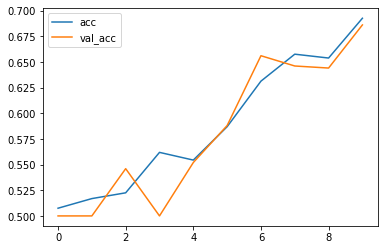

In [27]:
metrics[["acc", "val_acc"]].plot();

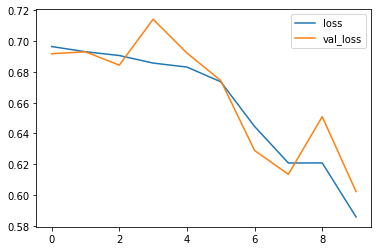

In [28]:
metrics[["loss", "val_loss"]].plot();

### Using augmented data

In [29]:
cnn_model.fit(X_train_val_gen, epochs = 30, validation_data = X_val_gen)

Epoch 1/30
50/50 [==============================] - 5s 86ms/step - loss: 0.6096 - acc: 0.6650 - val_loss: 0.5790 - val_acc: 0.7260
Epoch 2/30
50/50 [==============================] - 4s 88ms/step - loss: 0.5981 - acc: 0.6687 - val_loss: 0.5627 - val_acc: 0.7160
Epoch 3/30
50/50 [==============================] - 5s 96ms/step - loss: 0.5826 - acc: 0.7019 - val_loss: 0.5729 - val_acc: 0.6940
Epoch 4/30
50/50 [==============================] - 4s 88ms/step - loss: 0.5750 - acc: 0.6988 - val_loss: 0.5896 - val_acc: 0.6800
Epoch 5/30
50/50 [==============================] - 4s 89ms/step - loss: 0.5526 - acc: 0.7138 - val_loss: 0.5529 - val_acc: 0.7220
Epoch 6/30
50/50 [==============================] - 5s 91ms/step - loss: 0.5481 - acc: 0.7200 - val_loss: 0.5240 - val_acc: 0.7440
Epoch 7/30
50/50 [==============================] - 4s 87ms/step - loss: 0.5149 - acc: 0.7456 - val_loss: 0.5332 - val_acc: 0.7500
Epoch 8/30
50/50 [==============================] - 4s 84ms/step - loss: 0.5084 - a

In [30]:
metrics = pd.DataFrame(cnn_model.history.history)

<AxesSubplot:>

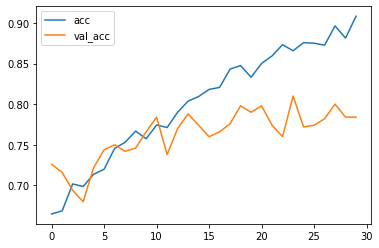

In [31]:
metrics[["acc", "val_acc"]].plot()

<AxesSubplot:>

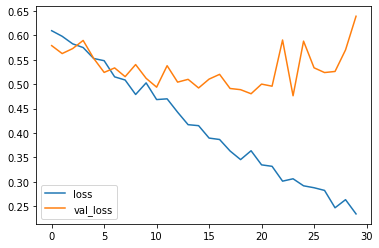

In [32]:
metrics[["loss", "val_loss"]].plot()

### Training with the whole training set

In [33]:
X_train = np.concatenate((X_train_val, X_val)) ## Concatenates X_train_val and X_val together and makes a new array
print(f"Length of X_train_val: {len(X_train_val)}")
print(f"Length of X_val: {len(X_val)}")
print(f"Length of X_train: {len(X_train)}")

y_train = np.concatenate((y_train_val, y_val))

Length of X_train_val: 1600
Length of X_val: 500
Length of X_train: 2100


In [34]:
cnn_model.fit(X_train, y_train, epochs = 30)

Epoch 1/30
66/66 [==============================] - 1s 9ms/step - loss: 0.3155 - acc: 0.8705
Epoch 2/30
66/66 [==============================] - 1s 11ms/step - loss: 0.2364 - acc: 0.9048
Epoch 3/30
66/66 [==============================] - 1s 9ms/step - loss: 0.2110 - acc: 0.9171
Epoch 4/30
66/66 [==============================] - 1s 9ms/step - loss: 0.1700 - acc: 0.9400
Epoch 5/30
66/66 [==============================] - 1s 9ms/step - loss: 0.1368 - acc: 0.9452
Epoch 6/30
66/66 [==============================] - 1s 8ms/step - loss: 0.1253 - acc: 0.9471
Epoch 7/30
66/66 [==============================] - 1s 9ms/step - loss: 0.0798 - acc: 0.9681
Epoch 8/30
66/66 [==============================] - 1s 9ms/step - loss: 0.1064 - acc: 0.9614
Epoch 9/30
66/66 [==============================] - 1s 9ms/step - loss: 0.1297 - acc: 0.9438
Epoch 10/30
66/66 [==============================] - 1s 9ms/step - loss: 0.1046 - acc: 0.9624
Epoch 11/30
66/66 [==============================] - 1s 9ms/step - l

              precision    recall  f1-score   support

           0       0.73      0.91      0.81       200
           1       0.88      0.67      0.76       200

    accuracy                           0.79       400
   macro avg       0.80      0.79      0.78       400
weighted avg       0.80      0.79      0.78       400



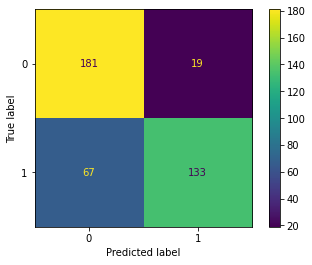

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = cnn_model.predict(X_test)
y_pred = np.round(y_pred)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

## Tansfer learning

In [36]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (100, 100, 3)) ## Creats VGG16 as base model

base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
______________________________________________________________

Choose VGG16 because the model isn't as large as Xception and would be easier to use

In [37]:
model = Sequential([ ## Makes a model with the VGG16 as a starting model and adds flatten, dropouts, fullyconected layer and output to the end.
    base_model,
    Flatten(),
    Dropout(.3),
    Dense(512, activation = "relu", kernel_initializer = "he_normal"),
    Dropout(.7),
    Dense(1, activation = "sigmoid")
], name = "VGG16_transfer")

for layer in base_model.layers: ## Freezes the trainable parameters of the VGG16 network
    layer.trainable = False

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["acc"])

model.summary()

Model: "VGG16_transfer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 17,075,009
Trainable params: 2,360,321
Non-trainable params: 14,714,688
________________________________

### Parameter tuning:
- Changed the dropout rate: To deactivate less nodes in the begining an more in the end of the network
    - So that more data goes into dense layer before the second dropout
- Changed the number of nodes in the dense layer of the MLP part of the network

#### Training model using none augmented data

In [38]:
model.fit(X_train_val, y_train_val, epochs = 30, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/30
50/50 [==============================] - 3s 39ms/step - loss: 0.6844 - acc: 0.7069 - val_loss: 0.3776 - val_acc: 0.8380
Epoch 2/30
50/50 [==============================] - 1s 24ms/step - loss: 0.4235 - acc: 0.8019 - val_loss: 0.3609 - val_acc: 0.8400
Epoch 3/30
50/50 [==============================] - 1s 23ms/step - loss: 0.3961 - acc: 0.8163 - val_loss: 0.3557 - val_acc: 0.8360
Epoch 4/30
50/50 [==============================] - 1s 23ms/step - loss: 0.3479 - acc: 0.8431 - val_loss: 0.3543 - val_acc: 0.8440
Epoch 5/30
50/50 [==============================] - 1s 23ms/step - loss: 0.3420 - acc: 0.8550 - val_loss: 0.3500 - val_acc: 0.8280
Epoch 6/30
50/50 [==============================] - 1s 23ms/step - loss: 0.3283 - acc: 0.8481 - val_loss: 0.3533 - val_acc: 0.8400
Epoch 7/30
50/50 [==============================] - 1s 23ms/step - loss: 0.3009 - acc: 0.8625 - val_loss: 0.3370 - val_acc: 0.8420
Epoch 8/30
50/50 [==============================] - 1s 23ms/step - loss: 0.2829 - a

In [39]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,loss,acc,val_loss,val_acc
0,0.684405,0.706875,0.377642,0.838
1,0.423480,0.801875,0.360943,0.840
2,0.396082,0.816250,0.355701,0.836
3,0.347926,0.843125,0.354287,0.844
4,0.342017,0.855000,0.349969,0.828


<AxesSubplot:>

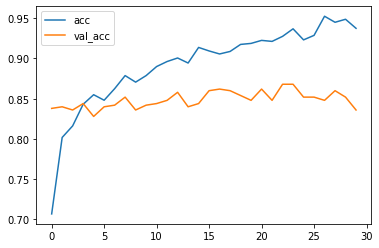

In [40]:
metrics[["acc", "val_acc"]].plot()

<AxesSubplot:>

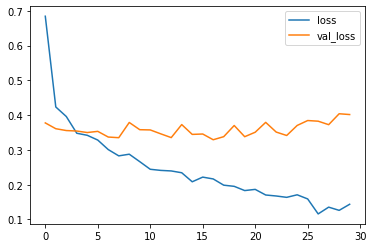

In [41]:
metrics[["loss", "val_loss"]].plot()

#### Using augmented data

In [42]:
model.fit(X_train_val_gen, epochs = 30, validation_data = X_val_gen, verbose = 1)

Epoch 1/30
50/50 [==============================] - 5s 100ms/step - loss: 0.3000 - acc: 0.8731 - val_loss: 0.3320 - val_acc: 0.8740
Epoch 2/30
50/50 [==============================] - 5s 92ms/step - loss: 0.3078 - acc: 0.8581 - val_loss: 0.3635 - val_acc: 0.8460
Epoch 3/30
50/50 [==============================] - 5s 102ms/step - loss: 0.2751 - acc: 0.8881 - val_loss: 0.3459 - val_acc: 0.8580
Epoch 4/30
50/50 [==============================] - 5s 97ms/step - loss: 0.2957 - acc: 0.8687 - val_loss: 0.3798 - val_acc: 0.8480
Epoch 5/30
50/50 [==============================] - 5s 92ms/step - loss: 0.2873 - acc: 0.8756 - val_loss: 0.3488 - val_acc: 0.8680
Epoch 6/30
50/50 [==============================] - 5s 97ms/step - loss: 0.2691 - acc: 0.8844 - val_loss: 0.3876 - val_acc: 0.8580
Epoch 7/30
50/50 [==============================] - 5s 92ms/step - loss: 0.2676 - acc: 0.8844 - val_loss: 0.3402 - val_acc: 0.8580
Epoch 8/30
50/50 [==============================] - 5s 96ms/step - loss: 0.2603 -

In [43]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,loss,acc,val_loss,val_acc
0,0.299964,0.873125,0.332047,0.874
1,0.307767,0.858125,0.363463,0.846
2,0.275093,0.888125,0.345871,0.858
3,0.295712,0.868750,0.379792,0.848
4,0.287325,0.875625,0.348759,0.868


<AxesSubplot:>

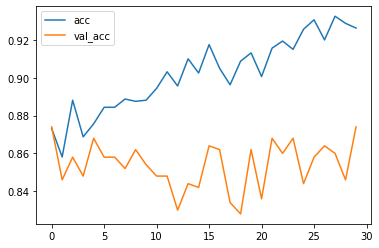

In [44]:
metrics[["acc", "val_acc"]].plot()

<AxesSubplot:>

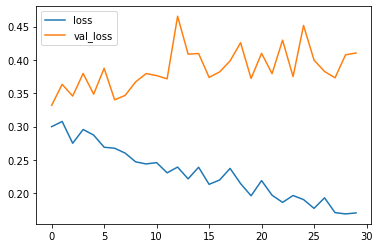

In [45]:
metrics[["loss", "val_loss"]].plot()

## Train on all the full training data

In [46]:
model.fit(X_train, y_train, epochs=30, verbose = 1)

Epoch 1/30
66/66 [==============================] - 1s 19ms/step - loss: 0.2293 - acc: 0.9133
Epoch 2/30
66/66 [==============================] - 1s 19ms/step - loss: 0.1946 - acc: 0.9229
Epoch 3/30
66/66 [==============================] - 1s 19ms/step - loss: 0.1737 - acc: 0.9333
Epoch 4/30
66/66 [==============================] - 1s 19ms/step - loss: 0.1767 - acc: 0.9319
Epoch 5/30
66/66 [==============================] - 1s 19ms/step - loss: 0.1696 - acc: 0.9271
Epoch 6/30
66/66 [==============================] - 1s 19ms/step - loss: 0.1435 - acc: 0.9452
Epoch 7/30
66/66 [==============================] - 1s 19ms/step - loss: 0.1367 - acc: 0.9486
Epoch 8/30
66/66 [==============================] - 1s 19ms/step - loss: 0.1350 - acc: 0.9490
Epoch 9/30
66/66 [==============================] - 1s 19ms/step - loss: 0.1241 - acc: 0.9505
Epoch 10/30
66/66 [==============================] - 1s 19ms/step - loss: 0.1384 - acc: 0.9452
Epoch 11/30
66/66 [==============================] - 1s 19m

## Predictions

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       200
           1       0.91      0.85      0.88       200

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



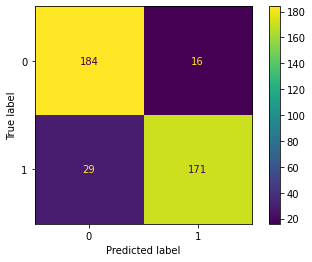

In [47]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

## VGG16 article summary

The VGG16 network came from the need to expand and improve on convolutional networks because of their increase in use in large scale image classification. The network uses Max Pooling after its convolutional layers. All the hidden layers in the network use ReLU as their activation function, a stack of convolutional layers is followed by three fully connected layers the first two contain 4096 channels and the last fully connected layer contains 1000 channels one channel for each class and the final layer after the fully connected layers is a softmax layer. 

The architecture of the network is made up of smaller convolutional filters, VGG16 uses 3x3 convolutional filters instead of 7x7 this results in less parameters which makes the network less complex and easier to regularize. It also makes the network better at seeing small features because of the use of 3x3 filters. 

During training the network utilizes mini batch gradient descent with a batch size of 256 to optimize the multinomial logistic regression. The training was regularized using weight decay with a L2 penalty of 5*10^-4. For the first two fully-connected layers dropout regularization was used with a dropout rate of 0.5. The starting learning rate of the VGG16 network was set to 10^-2 and was later decreased by 10 after the validation accuracy stopped improving. During testing the network is tested on full images instead of multiple crops at the same time, this is done because using multiple crops is less efficient because it requires a re-computation of the network.

## What is Transfer learning

Transfer learning works by taking a large network that has already been trained using very large quantity of data and freezing the pre trained parameters. Then you apply the your own MLP to the end to match what you are trying do get you network to do. After freezing the parameters and adding your own MLP it. You can fit the model with your own data.